다양한 기계학습 방법을 통해 online 뉴스 인기도 예측력를 극대화
 
최종 평가는 아래 test 데이터를 활용, 최종 예측 평가 지표는 MAE (Mean Absolute Error).

In [5]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from graphviz import Source
from IPython.display import Image
from sklearn.tree import export_graphviz

#from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## for classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

## for regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

sns.set_style("whitegrid")

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

In [7]:
path = "onlinenews.csv"
data = pd.read_csv(path, engine='python')
print("- Data has {} rows and {} columns.".format(*data.shape))
print("- Column names: ", list(data.columns))

X = data.drop([' shares'], axis=1)
y = data[' shares']

- Data has 39644 rows and 60 columns.
- Column names:  [' timedelta', ' n_tokens_title', ' n_tokens_content', ' n_unique_tokens', ' n_non_stop_words', ' n_non_stop_unique_tokens', ' num_hrefs', ' num_self_hrefs', ' num_imgs', ' num_videos', ' average_token_length', ' num_keywords', ' data_channel_is_lifestyle', ' data_channel_is_entertainment', ' data_channel_is_bus', ' data_channel_is_socmed', ' data_channel_is_tech', ' data_channel_is_world', ' kw_min_min', ' kw_max_min', ' kw_avg_min', ' kw_min_max', ' kw_max_max', ' kw_avg_max', ' kw_min_avg', ' kw_max_avg', ' kw_avg_avg', ' self_reference_min_shares', ' self_reference_max_shares', ' self_reference_avg_sharess', ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday', ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday', ' weekday_is_sunday', ' is_weekend', ' LDA_00', ' LDA_01', ' LDA_02', ' LDA_03', ' LDA_04', ' global_subjectivity', ' global_sentiment_polarity', ' global_rate_positive_words', ' global

데이터 6:2:2 Train valid test 구분

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=2015010720)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,
                                                      test_size=0.25,
                                                      random_state=2015010720)

# X_valid = scaler.transform(X_valid)

최적 파라미터 조정 없이 학습 및 테스트 진행

In [11]:
clf_dt = DecisionTreeRegressor(criterion='squared_error', max_depth=None)
clf_dt.fit(X_train, y_train)
y_train_pred = clf_dt.predict(X_train)
y_valid_pred = clf_dt.predict(X_valid)
y_test_pred = clf_dt.predict(X_test)

In [12]:
# Show train & validation accuracies
print('- MSE (Train)      : {:.4}'.format(mean_squared_error(y_train, y_train_pred)))
print('- MSE (Validation) : {:.4}'.format(mean_squared_error(y_valid, y_valid_pred)))
print('- MSE (test) : {:.4}'.format(mean_squared_error(y_test, y_test_pred)))
print('- MAE (Train)      : {:.4}'.format(mean_absolute_error(y_train, y_train_pred)))
print('- MAE (Validation) : {:}'.format(round(mean_absolute_error(y_valid, y_valid_pred))))
print('- MAE (Validation) : {:}'.format(round(mean_absolute_error(y_test, y_test_pred))))

- MSE (Train)      : 0.0
- MSE (Validation) : 2.662e+08
- MSE (test) : 3.521e+08
- MAE (Train)      : 0.0
- MAE (Validation) : 4093
- MAE (Validation) : 4396


최적 파라미터 조정 후 테스트 진행

In [13]:
max_depths = list(range(1, 10, 1))
validation_mse = []
dt_models = []
for max_depth in max_depths:
    clf_dt = DecisionTreeRegressor(criterion='squared_error', max_depth=max_depth)
    clf_dt.fit(X_train, y_train)
    dt_models.append(clf_dt)
    y_valid_pred = clf_dt.predict(X_valid)
    validation_mse.append(mean_squared_error(y_valid, y_valid_pred))

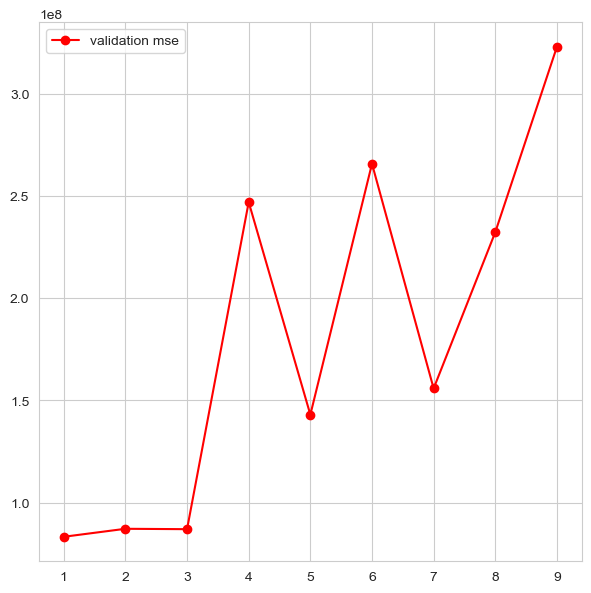

In [14]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(max_depths, validation_mse, color='red', marker='o', label='validation mse')
ax.legend(loc='best')
plt.show(fig)

In [15]:
best_model_idx, best_model_f1 = min(enumerate(validation_mse), key=lambda p: p[1])
y_test_pred = dt_models[best_model_idx].predict(X_test)
print('- mse (Test) : {:.4}'.format(mean_squared_error(y_test, y_test_pred)))
print('- mae (Test) : {:}'.format(round(mean_absolute_error(y_test, y_test_pred))))

- mse (Test) : 1.474e+08
- mae (Test) : 3113


최적 모델 시각화

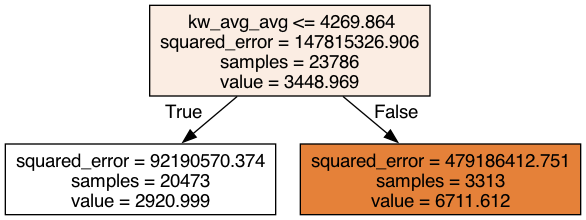

In [16]:
graph = Source(export_graphviz(dt_models[best_model_idx],
                               out_file=None,
                               feature_names=X.columns,
                               filled=True,
                               leaves_parallel=True))
png_bytes = graph.pipe(format='png')
Image(png_bytes)


모델의 중요변수 선택

In [17]:
imp = dt_models[best_model_idx].feature_importances_
imp = pd.DataFrame([X.columns, imp]).T
imp.columns = ['variables', 'importance']
print(imp[imp['importance'] != 0])

      variables importance
26   kw_avg_avg        1.0


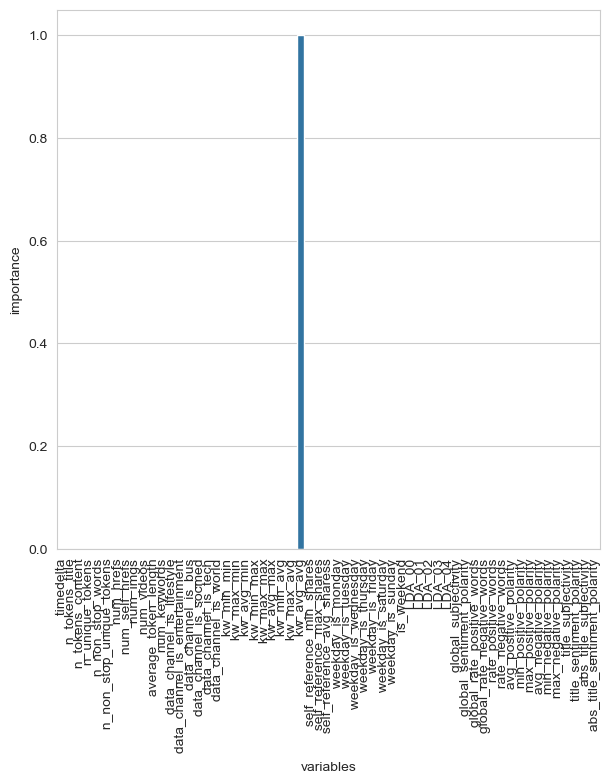

In [18]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.barplot(x='variables', y='importance', data=imp, ax=ax)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show(fig)

더 효과적인 알고리즘 적용

In [19]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf = RandomForestRegressor(n_estimators=50)
rf.fit(X_train, y_train)
y_test_pred_rf = rf.predict(X_test)
print('- mse (Test) : {:.4}'.format(mean_squared_error(y_test, y_test_pred_rf)))
print('- mae (Test) : {:}'.format(round(mean_absolute_error(y_test, y_test_pred_rf))))

- mse (Test) : 1.574e+08
- mae (Test) : 3429
